<a href="https://colab.research.google.com/github/khalil-alexander/get_forecast/blob/main/Copy_of_DataAnalytics2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <font color="red"> Pip install Astropy in google colab <font/>
### <font color="Green"> We install astropy in order to convert kilometre to longitatide later <font/>

In [1]:
!pip install astropy
!pip install country_converter
!pip install shapely
!pip install cartopy
!pip install geopandas
!pip install movingpandas
!pip install hvplot
!pip install holoviews
!pip install geoviews
!pip install global_land_mask
!pip install reverse_geocode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.9/161.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.3/547.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 26.6 MB/s eta 0:00:00


## <font color="red"> Install Moudles in google colab <font/>

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from astropy import coordinates as coord
from astropy import units as u
from astropy import time
from astropy.time import Time
from astropy.coordinates import Angle

In [4]:
import pandas as pd
from bs4 import BeautifulSoup
import requests as reqs
import xml.etree.ElementTree as ET
import io
import pprint
import json
import datetime

In [5]:
import geopandas as gpd
import movingpandas as mpd
import numpy as np
from geopy.geocoders import Nominatim

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.cm as mcm

In [7]:
import cartopy
import cartopy.crs as ccrs
import country_converter as coco
from cartopy.feature.nightshade import Nightshade
from global_land_mask import globe

In [8]:
from shapely import geometry as shpgeom
from shapely import wkt as shpwkt

In [9]:
import holoviews as hv
import hvplot.pandas
import geoviews

In [10]:
import os
from pathlib import Path
import datetime as dt
from datetime import timezone

In [11]:
from datetime import datetime
import datetime as dt
from datetime import timezone

In [12]:
import xarray as xr

In [13]:
from global_land_mask import globe
import reverse_geocode

In [14]:
import seaborn as sns

In [15]:
def create_latlon_positions(date: str, xyz: list[float]):
    now = Time(date, scale='utc')
    cartrep = coord.CartesianRepresentation(*xyz, unit=u.km)

    gcrs = coord.GCRS(cartrep, obstime = now)
    itrs = gcrs.transform_to(coord.ITRS(obstime = now))
    loc = coord.EarthLocation(*itrs.cartesian.xyz)

    return Angle(loc.lat).deg, Angle(loc.lon).deg


In [16]:
def get_latlon(row: pd.Series):
    date = row['Date'].strftime('%Y-%m-%d %H:%M:%S')
    xyz = [row['x units(km)'], row['y units(km)'], row['z units(km)']]
    return create_latlon_positions(date, xyz)




## <font color="red"> read_xml_DateFrame <font/>
### <font color="green">A function that reads an xml file and returns the specfic position the ISS is at during different time. <font/>

<font color="blue"> We pass in the url of an XML file:https://nasa-public-data.s3.amazonaws.com/iss-coords/current/ISS_OEM/ISS.OEM_J2K_EPH.xml
<font color="blue"> We use the XML file to webscrap data on the the position of the ISS and time the ISS was in that posistion.

<font color="blue"> In order to clean up the data we use Beautifulsoup

### <font color="green">What is Beautifulsoup? <font/>

<font color="blue">Beautifulsoup is a python libary that is used to pull XML and HTML files. In this case we want to pull out an XML file. <font/>

<font color="blue">The XML file we used to extract data from: https://nasa-public-data.s3.amazonaws.com/iss-coords/current/ISS_OEM/ISS.OEM_J2K_EPH.xml <font/>

In [17]:
def read_xml_DataFrame(url):
    """
    Do web scraping from an XML file to obtain time the International Space
    Station will be at a specfic postion and the speed it is going at.

    Parameters
    ----------
    url : String
        The url of the data in XML format you want to extract from.

    Return
    ------
    df : Pandas DataFrame
        The DataFrame containing the time the International Space Station is at
        a specfic position and the speed it is traveling.
    """
    # Get the xml request
    xml = reqs.get(url)

    # Use BeautifulSoup to Organize the XML file
    soup = BeautifulSoup(xml.content,"lxml")

    # Finds all the instances 'statevector' appeared in the xml file
    state_tag = soup.find_all('statevector')

    col_name = ['Date','x units(km)',
                'y units(km)','z units(km)',
                'x_dot(km/s)',
                'y_dot(km/s)','z_dot(km/s)']
    df = pd.DataFrame(columns=col_name)

    #Loops thorugh all elements to add rows in the empty xml_df
    for element in state_tag:
        # Turns element into text and splits the '\n'
        element = element.text.split('\n')
        # Deletes First empty String
        element.pop(0)
        # Deletes Last empty Sting
        element.pop(-1)
        # Removes the 'Z' in the elements first index
        element[0] = element[0][:-1]

        # Appending list into DataFrame by adding 1 row to the DataFrame
        #df = xml_df.append(pd.DataFrame(element, columns=col_name), ignore_index=True)
        df.loc[len(df)] = element


    # Turns the "Date" collumn into a Datetime object
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%jT%H:%M:%S.%f')
    # Sets the "Date" collumn into a Datetime object
    #df.set_index("Date", inplace=True)

    # Returns the Dataframe
    return df

In [18]:
xml_url = "https://nasa-public-data.s3.amazonaws.com/iss-coords/current/ISS_OEM/ISS.OEM_J2K_EPH.xml"
%time df = read_xml_DataFrame(xml_url)

CPU times: user 8.6 s, sys: 241 ms, total: 8.84 s
Wall time: 9.41 s


In [19]:
df

,Date,x units(km),y units(km),z units(km),x_dot(km/s),y_dot(km/s),z_dot(km/s)
0,2025-02-26 12:00:00.000,236.607189722756,-5167.4525798095301,4405.8223442860099,6.3567712722254601,-2.60482660992353,-3.3862048965773899
1,2025-02-26 12:04:00.000,1735.1270094085601,-5597.3535428241203,3442.5630659068402,6.054727659478,-0.95570969696164998,-4.5919578443920503
2,2025-02-26 12:08:00.000,3107.5793745853998,-5620.5647801946498,2228.4782502100802,5.31255548325157,0.76356765935201998,-5.4635731098841802
3,2025-02-26 12:12:00.000,4254.1703552240597,-5235.2592670174399,851.96959367903696,4.1840488528899202,2.4277441186495401,-5.9371498839938903
4,2025-02-26 12:16:00.000,5091.5432377902598,-4469.41233085761,-586.64491787329598,2.7515615632990298,3.9152942921593699,-5.9779466889292401
...,...,...,...,...,...,...,...
5408,2025-03-13 11:57:57.599,4386.7509798829697,4849.8896720993898,-1841.48821708367,-2.59139964259872,4.4791035142539597,5.6519322937979997
5409,2025-03-13 11:58:28.199,4304.85697053284,4984.0341863696203,-1667.4736081057099,-2.76062405159609,4.2876349412265098,5.7204412886574101
5410,2025-03-13 11:58:58.799,4217.8340117356202,5112.2404372730098,-1491.46680407757,-2.9265913497029699,4.0910201920137998,5.7821276311826901
5411,2025-03-13 11:59:29.400,4125.7848493602596,5234.3545160965896,-1313.6777742044101,-3.0891009969024901,3.8894932967357598,5.8369145344746398


In [20]:
df[['lat','lon']] = df.apply(get_latlon, axis=1, result_type='expand')

In [21]:
df = df[['Date','lat','lon']]

In [22]:
df

,Date,lat,lon
0,2025-02-26 12:00:00.000,40.603710,-63.764330
1,2025-02-26 12:04:00.000,30.629490,-50.125498
2,2025-02-26 12:08:00.000,19.314027,-39.377104
3,2025-02-26 12:12:00.000,7.330273,-30.191455
4,2025-02-26 12:16:00.000,-4.875548,-21.546412
...,...,...,...
5408,2025-03-13 11:57:57.599,-15.724899,57.304933
5409,2025-03-13 11:58:28.199,-14.200339,58.489145
5410,2025-03-13 11:58:58.799,-12.668313,59.660212
5411,2025-03-13 11:59:29.400,-11.129713,60.811850


In [23]:
def create_latlon_positions(date: str, xyz: list[float]):
    now = Time(date, scale='utc')
    cartrep = coord.CartesianRepresentation(*xyz, unit=u.km)

    gcrs = coord.GCRS(cartrep, obstime = now)
    itrs = gcrs.transform_to(coord.ITRS(obstime = now))
    loc = coord.EarthLocation(*itrs.cartesian.xyz)

    return Angle(loc.lat).deg, Angle(loc.lon).deg


In [24]:
def get_latlon(row: pd.Series):
    date = row['Date'].strftime('%Y-%m-%d %H:%M:%S')
    xyz = [row['x units(km)'], row['y units(km)'], row['z units(km)']]
    return create_latlon_positions(date, xyz)




In [25]:
# Writing a function to return if there is land in a given latitude/longitude
# Function returns 1 if there is land and returns 0 if there is ocean.
def get_land_flag(row):
    """
    Extract the land_flag given the latitude/longitude information.
    This function provides if there is land in a given latitude/longitude. If
    not then we can assume the given latitude/longitude is on the ocean.

    Parameters
    ----------
    lat : float
       Latitude of the location
    lon : float
       Longitude of the location

    Returns
    -------
    land_flag : boolen
       If land_flag is true or not
    """
    # Gets checks if there is land in the given latitude/longitude
    land_flag = globe.is_land(row['lat'],row['lon'])
    # Returns land flag
    return land_flag

In [26]:
# Getting the name of a country with latitude/longitude
# Returns the name of the country
def get_country_name(lat: float, lon: float) -> str:
    """
    Extract the country name given the latitude/longitude information.
    This function provides a country name even when a location is on
    the ocean. We wish it was not the case.

    Parameters
    ----------
    lat : float
       Latitude of the location
    lon : float
       Longitude of the location

    Returns
    -------
    country : str
       Country name (empty string if no country)
    """
    # Turn latitude and longitude into a tuple
    lat_lon = (lat, lon),
    # Get location with geocode
    loc_name = reverse_geocode.search(lat_lon)
    # Returns Country name
    return loc_name[0].get('country', '')

In [27]:
# Using the function get_county_name we obtain the country if land_flag is true
# Returns name of country if land_flag is true, otherwise returns 'Ocean'
def obtain_country_name(row):
    """
    Extract the country name given the latitude/longitude information.
    This function provides a country name even when a location is on
    the ocean. We wish it was not the case.

    Parameters
    ----------
    row: Pandas Dataframe
       Dataframe expected to contain the latitude and longitude

       lat : float
         Latitude of the location
       lon : float
         Longitude of the location

    Returns
    -------
    country : str
       Country name (empty string if no country)
    """
    # Checks if land_flag is true
    if row['land_flag'] == 1:
        # Gets latitude and longitude
        lat = row['lat']
        lon = row['lon']
        # Gets country name
        country = get_country_name(lat, lon)
        # Retuns country name
        return country
    else:
        # Returns ocean if land_flag is false
        return "Ocean"

In [28]:
def get_overpassed_countries(df: pd.DataFrame, country_dict: dict):
    """
    Counts the amount of countrys the ISS flys over.

    Parameters
    ----------
    df : Pandas DataFrame

    Return
    ------
    count : Int
        The number of countrys the ISS flys over.
    """
    list_countries = df["Country"].unique().tolist()
    list_countries.remove("Ocean")

    for country in list_countries:
        if country in country_dict:
            country_dict[country] += 1
        else:
            country_dict[country] = 1
    return country_dict


In [29]:
def count_countrys(df: pd.DataFrame):
    """
    Counts the amount of countrys the ISS flys over.

    Parameters
    ----------
    df : Pandas DataFrame

    Return
    ------
    count : Int
        The number of countrys the ISS flys over.
    """
    country_dict = {}
    previous_name = ""
    country_count = 0
    for name, land_flag in zip(df['Country'], df['land_flag']):
        if (previous_name != name) and (name not in country_dict) and land_flag == True:
            if name not in country_dict:
                country_dict[name] = 1
                country_count += 1

        previous_name = name
    print(country_dict)
    print(country_count)
    return country_count


In [30]:
def create_list_orbits(df: pd.DataFrame) -> list:
    """

    """
    list_orbits = list()
    temp_df = df['lon']
    first_index = 0
    second_index = 0


    for i in range(len(temp_df)-1):
        if (temp_df[i] > 0) and (temp_df[i+1] < 0):
            second_index = i+1
            list_orbits.append(df[first_index:second_index])
            first_index = second_index

    list_orbits.append(df[second_index:])


    return list_orbits

In [31]:
def get_interpolated_data(df: pd.DataFrame, seconds='20s') -> pd.DataFrame:
    """

    """

    df.rename(columns={'Date': 't'}, inplace=True)

    df.set_index('t', inplace=True)
    ds = df.to_xarray()

    start_date = df.index[0] + dt.timedelta(seconds=5)
    start_date = datetime.fromtimestamp(start_date.timestamp())
    start_date = start_date.strftime('%Y-%m-%dT%H:%M:%S')

    end_date = df.index[-1] - dt.timedelta(seconds=5)
    end_date = datetime.fromtimestamp(end_date.timestamp())
    end_date = end_date.strftime('%Y-%m-%dT%H:%M:%S')

    new_dates = pd.date_range(start_date, end_date, freq=seconds)
    interpolated_data = ds.interp(t=new_dates, method='linear')
    interpolated_df = interpolated_data.to_dataframe()

    return interpolated_df

In [32]:
def interpolate_orbits(df_list: list, seconds='20s') -> list:
    count = 0
    new_df_list = list()
    for element in df_list:
        element = get_interpolated_data(element, seconds)
        element['land_flag'] = element.apply(get_land_flag, axis=1, result_type='expand')
        element['Country'] = element.apply(obtain_country_name, axis=1, result_type='expand')
        new_df_list.append(element)


    return new_df_list



In [33]:
def get_all_countrys(df_list: list) -> dict:
    """

    """
    country_dict = dict()
    for df in df_list:
        country_dict = get_overpassed_countries(df, country_dict)
    return country_dict

In [34]:
orbit_list = create_list_orbits(df)

In [69]:
orbit_list

[                           lat         lon
 t                                         
 2025-02-26 12:00:00  40.603710  -63.764330
 2025-02-26 12:04:00  30.629490  -50.125498
 2025-02-26 12:08:00  19.314027  -39.377104
 2025-02-26 12:12:00   7.330273  -30.191455
 2025-02-26 12:16:00  -4.875548  -21.546412
 2025-02-26 12:20:00 -16.930583  -12.549176
 2025-02-26 12:24:00 -28.415386   -2.222723
 2025-02-26 12:28:00 -38.721862   10.687122
 2025-02-26 12:32:00 -46.856351   27.666128
 2025-02-26 12:36:00 -51.347007   49.318017
 2025-02-26 12:40:00 -50.888991   72.989181
 2025-02-26 12:44:00 -45.634127   93.899765
 2025-02-26 12:48:00 -37.010521  110.073921
 2025-02-26 12:52:00 -26.421306  122.431732
 2025-02-26 12:56:00 -14.778986  132.453237
 2025-02-26 13:00:00  -2.647992  141.335914
 2025-02-26 13:04:00   9.566359  150.029038
 2025-02-26 13:08:00  21.483518  159.436563
 2025-02-26 13:12:00  32.625180  170.630328,
                            lat         lon
 t                             

In [35]:
def comp_interpolated_orbits(orbit_list: list, seconds='20s') -> list:
    """
    Reads the dataframe and returns dictionary of countries the ISS flys over.
    Parameters
    ----------
    df : Pandas DataFrame

    Return
    ------
    interpolated_list : list
        A list of orbits with the interpolated data.
        A dictionary of countrys the ISS flys over.
    """

    # Go through each orbit and interpolate each orbit
    interpolated_list = interpolate_orbits(orbit_list, seconds=seconds)
    # Loop through the list and add columns land_flag and Country to the element
    for element in interpolated_list:
        element['land_flag'] = element.apply(get_land_flag, axis=1, result_type='expand')
        element['Country'] = element.apply(obtain_country_name, axis=1, result_type='expand')
    return interpolated_list

In [36]:
interpolated_list = comp_interpolated_orbits(orbit_list, seconds='20s')
country_list = get_all_countrys(interpolated_list)

In [37]:
len(country_list)

170

In [98]:
def get_all(df: pd.DataFrame, seconds='20s') -> dict:
    """
    Reads the dataframe and returns dictionary of countries the ISS flys over.
    Parameters
    ----------
    df : Pandas DataFrame

    Return
    ------
    country_dict : dict
        A dictionary of countrys the ISS flys over.
    """
    # Make a deep copy of the dataframe
    mydf = df.copy()
    # Create a list of orbits with the copy of the dataframe
    orbit_list = create_list_orbits(mydf)

    # Only consider orbits with at least two points
    orbit_list = [item for item in orbit_list if len(item) > 1]


    # Go through each orbit and interpolate each orbit
    interpolated_list = interpolate_orbits(orbit_list, seconds=seconds)

    # Loop through the list and add columns land_flag and Country to the element
    for element in interpolated_list:
        element['land_flag'] = element.apply(get_land_flag, axis=1, result_type='expand')
        element['Country'] = element.apply(obtain_country_name, axis=1, result_type='expand')

    country_dict = get_all_countrys(interpolated_list)
    return country_dict


In [39]:
%time test_list_15 = get_all(df, seconds='15s')

Index(['lat', 'lon', 'land_flag', 'Country'], dtype='object')
CPU times: user 40.3 s, sys: 119 ms, total: 40.4 s
Wall time: 40.9 s


In [40]:
%time test_list_20 = get_all(df, seconds='20s')

Index(['lat', 'lon', 'land_flag', 'Country'], dtype='object')
CPU times: user 31 s, sys: 70.7 ms, total: 31.1 s
Wall time: 31.6 s


In [41]:
%time test_list_25 = get_all(df, seconds='25s')

Index(['lat', 'lon', 'land_flag', 'Country'], dtype='object')
CPU times: user 25.8 s, sys: 63.9 ms, total: 25.9 s
Wall time: 26.1 s


In [42]:
%time test_list_30 = get_all(df, seconds='30s')

Index(['lat', 'lon', 'land_flag', 'Country'], dtype='object')
CPU times: user 21.5 s, sys: 70.3 ms, total: 21.6 s
Wall time: 21.8 s


In [43]:
%time test_list_10 = get_all(df, seconds='10s')

Index(['lat', 'lon', 'land_flag', 'Country'], dtype='object')
CPU times: user 59.5 s, sys: 165 ms, total: 59.6 s
Wall time: 1min


In [44]:
%time test_list_5 = get_all(df, seconds='5s')

Index(['lat', 'lon', 'land_flag', 'Country'], dtype='object')
CPU times: user 2min, sys: 310 ms, total: 2min
Wall time: 2min 11s


In [46]:
keys15 = set(test_list_15.keys())
keys20 = set(test_list_20.keys())
keys25 = set(test_list_25.keys())
keys30 = set(test_list_30.keys())
keys10 = set(test_list_10.keys())
keys5 = set(test_list_5.keys())

In [47]:
print(len(keys5))
print(len(keys10))
print(len(keys15))
print(len(keys20))
print(len(keys25))
print(len(keys30))

181
177
168
170
164
160


In [48]:
keys30-keys5

set()

Create a table
First column: Freq
Second column: How long it takes to run: Computing time
Third Column: How many countries does the ISS pass: Number of Countries and

### Data was gathered on Feburary 26th 12:18pm EST from a function that interpolates data then returns a dictionary of the countrys
| Frequency in seconds(s) | Computing time in seconds (s) | Number of countries and territories ISS pass |
|-------------------------|-------------------------------|--------------------
| 5                       |             104               |        180
| 10                      |              60               |        179
| 15                      |             37.7              |        169
| 20                      |             28.5              |        165
| 25                      |             23.3              |        164
| 30                      |             20.1              |        164

In [49]:
keys20-keys15

{'Antigua and Barbuda',
 'Comoros',
 'Hong Kong',
 'Ireland',
 'Malta',
 'New Caledonia',
 'Saint Pierre and Miquelon'}

In [50]:
keys15-keys10

{'Bahrain', 'Lebanon', 'Marshall Islands'}

In [51]:
keys10-keys15

{'Antigua and Barbuda',
 'Comoros',
 'Fiji',
 'French Polynesia',
 'Grenada',
 'Hong Kong',
 'Ireland',
 'Macao',
 'Malta',
 'New Caledonia',
 'Saint Pierre and Miquelon',
 'Singapore'}

In [52]:
keys10-keys20

{'Cape Verde',
 'Fiji',
 'French Polynesia',
 'Grenada',
 'Liechtenstein',
 'Macao',
 'Singapore'}

In [53]:
keys30-keys10

set()

In [54]:
df

,Date,lat,lon
0,2025-02-26 12:00:00.000,40.603710,-63.764330
1,2025-02-26 12:04:00.000,30.629490,-50.125498
2,2025-02-26 12:08:00.000,19.314027,-39.377104
3,2025-02-26 12:12:00.000,7.330273,-30.191455
4,2025-02-26 12:16:00.000,-4.875548,-21.546412
...,...,...,...
5408,2025-03-13 11:57:57.599,-15.724899,57.304933
5409,2025-03-13 11:58:28.199,-14.200339,58.489145
5410,2025-03-13 11:58:58.799,-12.668313,59.660212
5411,2025-03-13 11:59:29.400,-11.129713,60.811850


In [55]:
def get_range(df: pd.DataFrame ,start_date: str, end_date: str):
    """
    Reads DataFrame, then takes the range between the start and end date.
    ----------
    df : Pandas DataFrame

    Return
    ------
    df : Pandas DataFrame
        A specific range of the df from a start date to an end date.
    """

    start_date = dt.datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')

    end_date = dt.datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S')

    for element in df["Date"]:
        if element >= start_date:
            start_date = element
            break
    for element in df["Date"]:
        if element >= end_date:
            end_date = element
            break
    print(start_date)
    print(end_date)
    print(type(start_date))
    print(type(end_date))

    #start_num = df.loc[(df['Date'] >= start_date)]
    #print(start_num)
    #end_num = df.loc[(df['Date'] <= end_date)]
    #print(end_num)
    return df.loc[(df['Date'] >= start_date) & (df['Date'] <= end_date)].reset_index(drop=True)



In [56]:
start_date = dt.datetime.now()

In [57]:
start_date

datetime.datetime(2025, 2, 27, 17, 15, 33, 521526)

In [58]:
end_date = dt.datetime.now() + dt.timedelta(days=1)

In [59]:
start_date = start_date.strftime("%Y-%m-%d %H:%M:%S")

In [60]:
end_date = end_date.strftime("%Y-%m-%d %H:%M:%S")

In [61]:
day_df = get_range(df, start_date, end_date)

2025-02-27 17:17:00
2025-02-28 17:16:27
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


test with how many countries fly over the new get_range function (use 5s freqency)

In [81]:
df

,Date,lat,lon
0,2025-02-26 12:00:00.000,40.603710,-63.764330
1,2025-02-26 12:04:00.000,30.629490,-50.125498
2,2025-02-26 12:08:00.000,19.314027,-39.377104
3,2025-02-26 12:12:00.000,7.330273,-30.191455
4,2025-02-26 12:16:00.000,-4.875548,-21.546412
...,...,...,...
5408,2025-03-13 11:57:57.599,-15.724899,57.304933
5409,2025-03-13 11:58:28.199,-14.200339,58.489145
5410,2025-03-13 11:58:58.799,-12.668313,59.660212
5411,2025-03-13 11:59:29.400,-11.129713,60.811850


In [62]:
day_df

,Date,lat,lon
0,2025-02-27 17:17:00,51.521475,170.107103
1,2025-02-27 17:21:00,47.436330,-167.841987
2,2025-02-27 17:25:00,39.551285,-150.406694
3,2025-02-27 17:29:00,29.376777,-137.177924
4,2025-02-27 17:33:00,17.956921,-126.670276
...,...,...,...
356,2025-02-28 17:00:27,-25.323577,-87.682876
357,2025-02-28 17:04:27,-36.032329,-75.635847
358,2025-02-28 17:08:27,-44.895240,-59.924540
359,2025-02-28 17:12:27,-50.556148,-39.483585


In [84]:
day_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361 entries, 0 to 360
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    361 non-null    datetime64[ns]
 1   lat     361 non-null    float64       
 2   lon     361 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 8.6 KB


In [86]:
day_df.isnull().sum()

,0
Date,0
lat,0
lon,0


In [87]:
try:
    day_dict = get_all(day_df, seconds='5s')
except ValueError:  #raised if `y` is empty.
    pass

In [99]:
day_dict = get_all(day_df, seconds='15s')

Got list_orbits 1 16
Got list_orbits 2 15
Got interpolated_list
Index(['lat', 'lon', 'land_flag', 'Country'], dtype='object')


In [100]:
day_dict

{'Chile': 5,
 'Argentina': 7,
 'South Africa': 2,
 'India': 2,
 'China': 6,
 'Mongolia': 4,
 'Russian Federation': 7,
 'Namibia': 2,
 'Angola': 2,
 'Congo, The Democratic Republic of the': 2,
 'Burundi': 1,
 'Rwanda': 1,
 'Uganda': 2,
 'Kenya': 2,
 'Ethiopia': 1,
 'Eritrea': 1,
 'Yemen': 2,
 'Saudi Arabia': 2,
 'Qatar': 1,
 'Iran, Islamic Republic of': 3,
 'Afghanistan': 2,
 'Turkmenistan': 1,
 'Uzbekistan': 2,
 'Tajikistan': 2,
 'Kyrgyzstan': 1,
 'Kazakhstan': 5,
 'Cameroon': 1,
 'Chad': 2,
 'Libyan Arab Jamahiriya': 3,
 'Egypt': 2,
 'Israel': 1,
 'Jordan': 1,
 'Syrian Arab Republic': 1,
 'Turkey': 2,
 'Azerbaijan': 1,
 'Japan': 2,
 'Liberia': 1,
 'Sierra Leone': 1,
 'Guinea': 1,
 'Mali': 2,
 'Algeria': 2,
 'Greece': 2,
 'Bulgaria': 1,
 'Ukraine': 4,
 'Paraguay': 1,
 'Brazil': 3,
 'Spain': 2,
 'France': 3,
 'Italy': 2,
 'Austria': 1,
 'Hungary': 2,
 'Slovakia': 2,
 'Poland': 2,
 'Indonesia': 4,
 'Australia': 5,
 'New Zealand': 1,
 'Peru': 2,
 'Guyana': 1,
 'Belgium': 2,
 'Germany': 2,

In [71]:
#orbit_list = create_list_orbits(day_df)

In [77]:
#%time daily_dict = comp_interpolated_orbits(orbit_list, seconds='5s')

KeyError: "None of ['t'] are in the columns"

In [101]:
len(day_dict)

103

### When have country list, create a bar plot where the list of countries, reorder by decreasing order of the number of times the ISS passes over the country.

In [102]:
day_items = sorted(day_dict.items(), key=lambda x: x[1], reverse=True)
day_items

[('Argentina', 7),
 ('Russian Federation', 7),
 ('United States', 7),
 ('China', 6),
 ('Canada', 6),
 ('Chile', 5),
 ('Kazakhstan', 5),
 ('Australia', 5),
 ('Mongolia', 4),
 ('Ukraine', 4),
 ('Indonesia', 4),
 ('Iran, Islamic Republic of', 3),
 ('Libyan Arab Jamahiriya', 3),
 ('Brazil', 3),
 ('France', 3),
 ('Mexico', 3),
 ('South Africa', 2),
 ('India', 2),
 ('Namibia', 2),
 ('Angola', 2),
 ('Congo, The Democratic Republic of the', 2),
 ('Uganda', 2),
 ('Kenya', 2),
 ('Yemen', 2),
 ('Saudi Arabia', 2),
 ('Afghanistan', 2),
 ('Uzbekistan', 2),
 ('Tajikistan', 2),
 ('Chad', 2),
 ('Egypt', 2),
 ('Turkey', 2),
 ('Japan', 2),
 ('Mali', 2),
 ('Algeria', 2),
 ('Greece', 2),
 ('Spain', 2),
 ('Italy', 2),
 ('Hungary', 2),
 ('Slovakia', 2),
 ('Poland', 2),
 ('Peru', 2),
 ('Belgium', 2),
 ('Germany', 2),
 ('Pakistan', 2),
 ('Thailand', 2),
 ('Malaysia', 2),
 ('Haiti', 2),
 ('Burundi', 1),
 ('Rwanda', 1),
 ('Ethiopia', 1),
 ('Eritrea', 1),
 ('Qatar', 1),
 ('Turkmenistan', 1),
 ('Kyrgyzstan', 1),


In [116]:
day_df = pd.DataFrame(day_items, columns=['Countries', 'Count'])

In [117]:
day_df

,Countries,Count
0,Argentina,7
1,Russian Federation,7
2,United States,7
3,China,6
4,Canada,6
...,...,...
98,Philippines,1
99,Bolivia,1
100,Uruguay,1
101,Myanmar,1


In [135]:
new_day_df = day_df[0:25]

In [122]:
new_df = pd.DataFrame(columns=['Countries', 'Count'])

In [123]:
new_df

,Countries,Count


Pandas: groupby,


In [129]:
for element in day_df:
    print(element)
    break
    if element.count > 1:
        new_df.append(element)

ValueError: too many values to unpack (expected 2)

In [103]:
day_dict = dict(day_items)

In [104]:
new_dict = dict()

In [105]:
for key, value in day_dict.items():
    if value >= 5:
        new_dict[key] = value

In [106]:
new_dict

{'Argentina': 7,
 'Russian Federation': 7,
 'United States': 7,
 'China': 6,
 'Canada': 6,
 'Chile': 5,
 'Kazakhstan': 5,
 'Australia': 5}

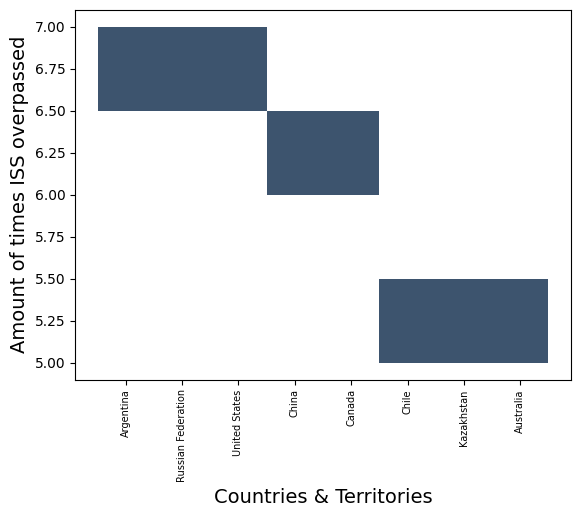

In [107]:
ax = sns.histplot(data=day_dict, x=new_dict.keys(), y=new_dict.values())
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={'fontsize': 7})
plt.xlabel("Countries & Territories", fontsize=14)
plt.ylabel("Amount of times ISS overpassed", fontsize=14)
plt.show()

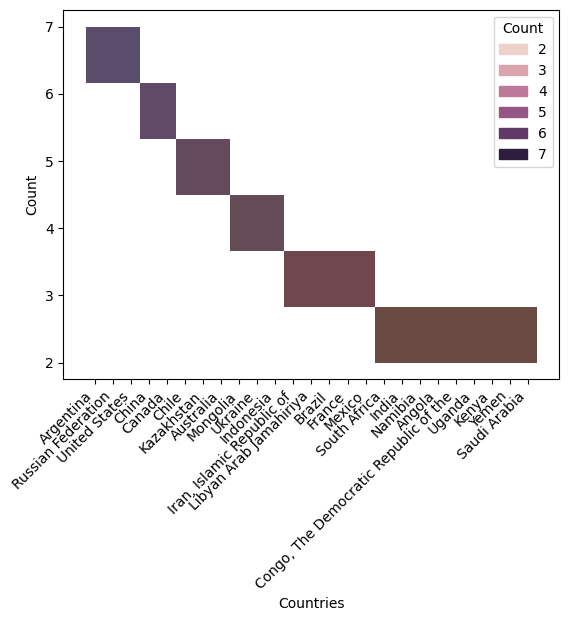

In [138]:
sns.histplot(data=new_day_df, x="Countries", y="Count", hue="Count", multiple="stack")
plt.xticks(rotation=45, ha='right')
plt.show()

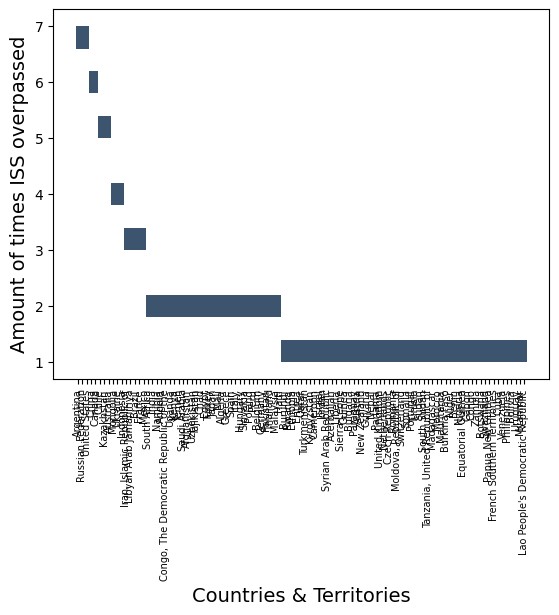

In [109]:
ax = sns.histplot(data=day_dict, x=day_dict.keys(), y=day_dict.values())
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={'fontsize': 7})
plt.xlabel("Countries & Territories", fontsize=14)
plt.ylabel("Amount of times ISS overpassed", fontsize=14)
plt.show()

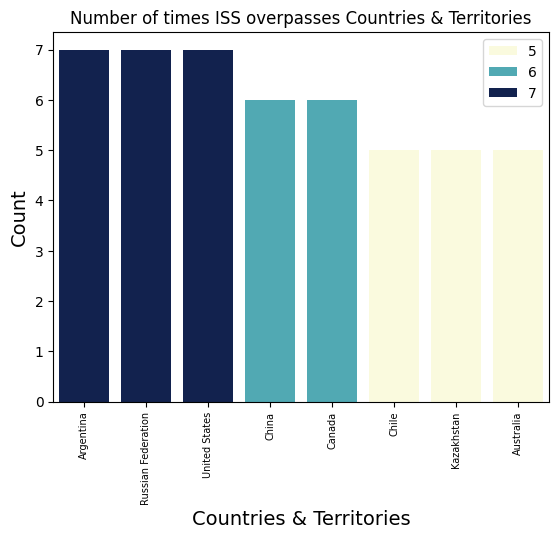

In [111]:
ax = sns.barplot(data=new_dict, x=new_dict.keys(), y=new_dict.values(), palette="YlGnBu", hue=new_dict.values())
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={'fontsize': 7})
plt.xlabel("Countries & Territories", fontsize=14)
plt.ylabel("Count", fontsize=14, )
plt.title("Number of times ISS overpasses Countries & Territories")
plt.show()

In [ ]:
plotdf=pd.DataFrame(new_dict,index=0)
plotdf

TypeError: Index(...) must be called with a collection of some kind, 0 was passed

KeyError: 'pclass'

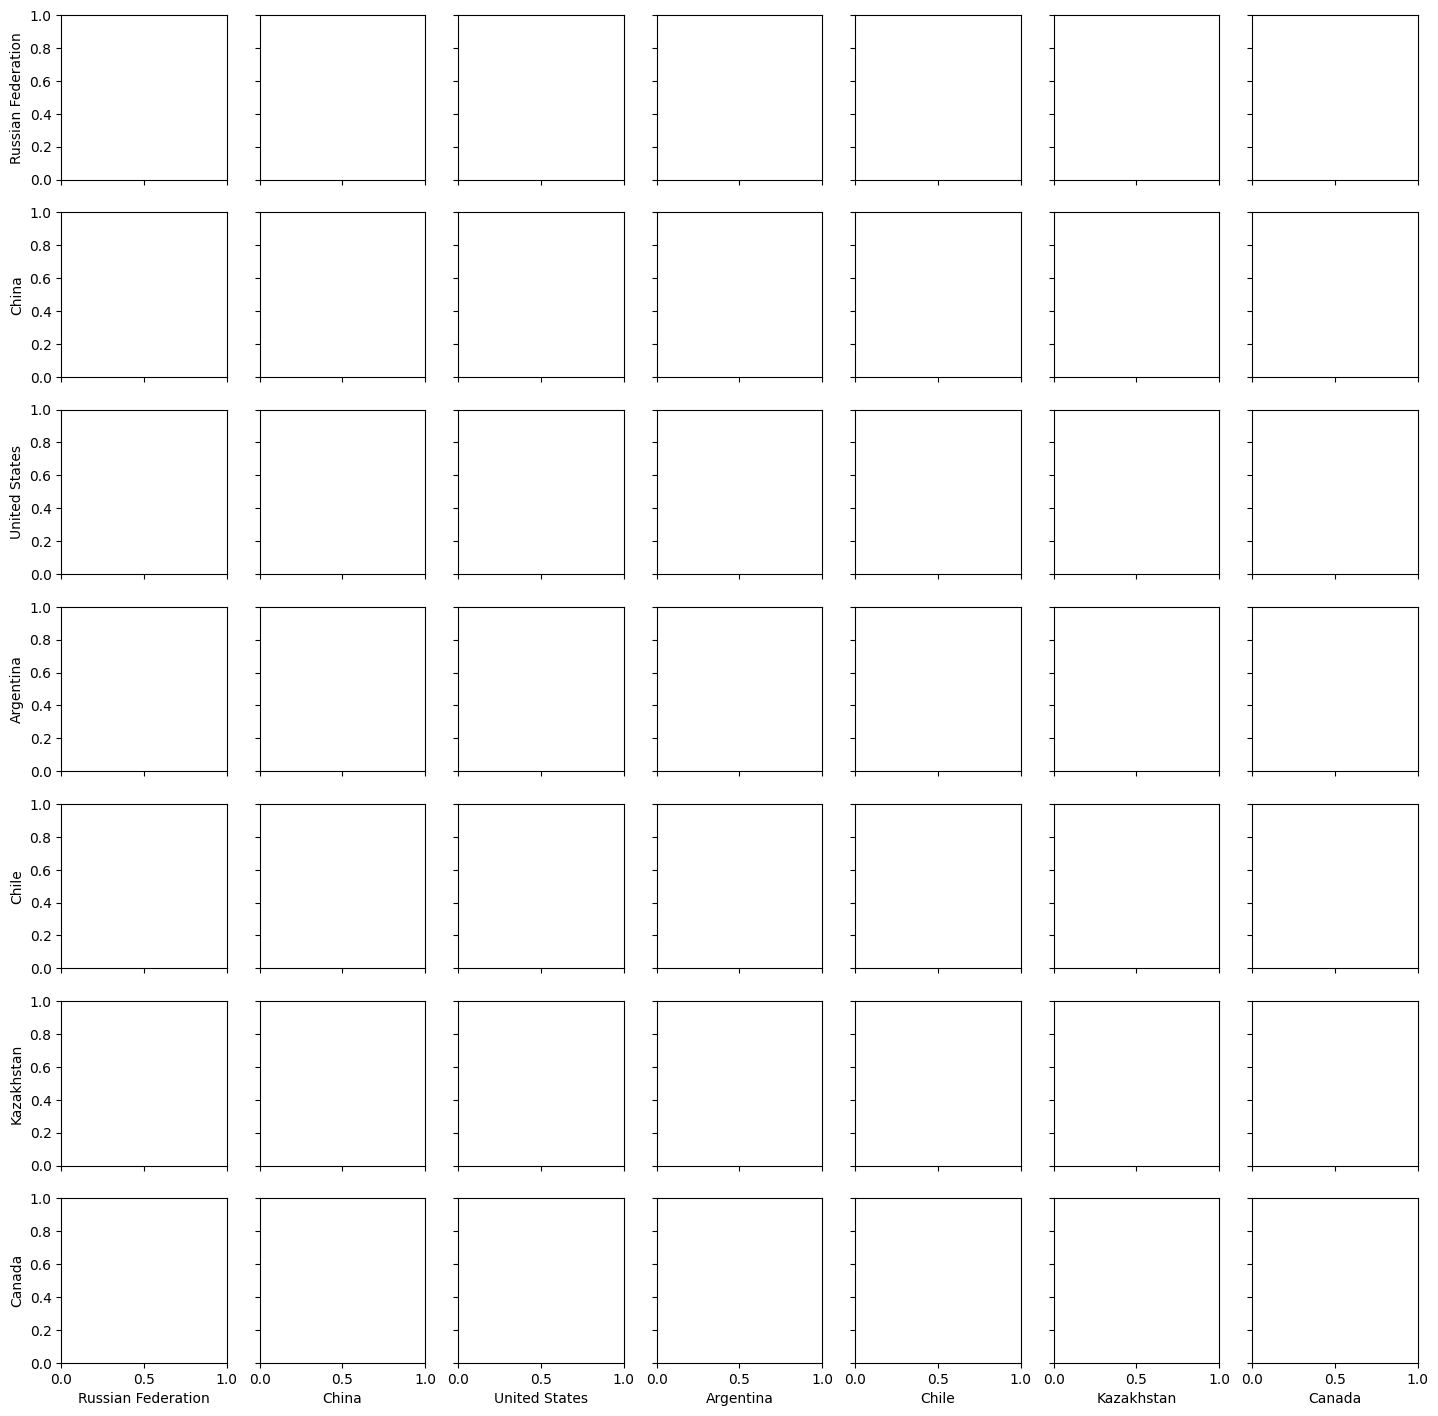

In [ ]:
ax = sns.pairplot(plotdf, hue="pclass")#, x=new_dict.keys(), y=new_dict.values(), palette="YlGnBu", hue=new_dict.values())
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={'fontsize': 7})
plt.xlabel("Countries & Territories", fontsize=14)
plt.ylabel("Amount of times ISS overpassed", fontsize=14)
plt.show()

In [ ]:
day_dict.items()

dict_items([('Thailand', 3), ("Lao People's Democratic Republic", 3), ('Vietnam', 3), ('China', 8), ("Korea, Democratic People's Republic of", 2), ('Russian Federation', 8), ('Chile', 5), ('Argentina', 5), ('Madagascar', 1), ('India', 3), ('Nepal', 1), ('Bhutan', 1), ('Mongolia', 5), ('South Africa', 2), ('Botswana', 1), ('Zimbabwe', 1), ('Zambia', 2), ('Malawi', 2), ('Tanzania, United Republic of', 1), ('Kenya', 2), ('Somalia', 2), ('Oman', 2), ('Pakistan', 2), ('Falkland Islands (Malvinas)', 1), ('Angola', 1), ('Congo, The Democratic Republic of the', 2), ('Congo', 1), ('Central African Republic', 2), ('South Sudan', 1), ('Sudan', 2), ('Egypt', 2), ('Saudi Arabia', 2), ('Iraq', 2), ('Iran, Islamic Republic of', 2), ('Turkmenistan', 2), ('Uzbekistan', 1), ('Kazakhstan', 4), ('Japan', 3), ('Ghana', 1), ('Togo', 1), ('Benin', 1), ('Nigeria', 2), ('Niger', 2), ('Libyan Arab Jamahiriya', 2), ('Greece', 1), ('Turkey', 2), ('Georgia', 1), ('Korea, Republic of', 2), ('Uruguay', 1), ('Brazil'

create new function with country name, return how many time it will fly over that country

In [ ]:
for key, value in day_dict.items():
  print(f"Key:{key}, Value:{value}")

Key:Thailand, Value:3
Key:Lao People's Democratic Republic, Value:3
Key:Vietnam, Value:3
Key:China, Value:8
Key:Korea, Democratic People's Republic of, Value:2
Key:Russian Federation, Value:8
Key:Chile, Value:5
Key:Argentina, Value:5
Key:Madagascar, Value:1
Key:India, Value:3
Key:Nepal, Value:1
Key:Bhutan, Value:1
Key:Mongolia, Value:5
Key:South Africa, Value:2
Key:Botswana, Value:1
Key:Zimbabwe, Value:1
Key:Zambia, Value:2
Key:Malawi, Value:2
Key:Tanzania, United Republic of, Value:1
Key:Kenya, Value:2
Key:Somalia, Value:2
Key:Oman, Value:2
Key:Pakistan, Value:2
Key:Falkland Islands (Malvinas), Value:1
Key:Angola, Value:1
Key:Congo, The Democratic Republic of the, Value:2
Key:Congo, Value:1
Key:Central African Republic, Value:2
Key:South Sudan, Value:1
Key:Sudan, Value:2
Key:Egypt, Value:2
Key:Saudi Arabia, Value:2
Key:Iraq, Value:2
Key:Iran, Islamic Republic of, Value:2
Key:Turkmenistan, Value:2
Key:Uzbekistan, Value:1
Key:Kazakhstan, Value:4
Key:Japan, Value:3
Key:Ghana, Value:1
Key

In [ ]:
def count_countryoverpass(count_dict: dict, country: str) -> int:
    """
    Counts the amount of times the ISS flies over a country.

    Parameters
    ----------
    count_dict : Dictionary

    Return
    ------
    count : Int
        The number of times the ISS passes over a country.
    """


    for key, value in count_dict.items():
        if key == country:
            return value
    print("Country not found")
    return 0

In [ ]:
count_countryoverpass(day_dict, "United States")

6

given latitude and longitude return how many times the ISS will fly over it

In [ ]:
day_df[['lat','lon']]

,lat,lon
0,12.902708,99.121298
1,24.654294,108.896748
2,35.462098,120.805756
3,44.478117,136.308379
4,50.363628,156.540868
...,...,...
356,33.482009,-124.515537
357,22.448645,-113.134186
358,10.595203,-103.637996
359,-1.588601,-94.935658


In [ ]:
day_df

,Date,lat,lon
0,2025-02-21 18:32:00,12.902708,99.121298
1,2025-02-21 18:36:00,24.654294,108.896748
2,2025-02-21 18:40:00,35.462098,120.805756
3,2025-02-21 18:44:00,44.478117,136.308379
4,2025-02-21 18:48:00,50.363628,156.540868
...,...,...,...
356,2025-02-22 18:16:00,33.482009,-124.515537
357,2025-02-22 18:20:00,22.448645,-113.134186
358,2025-02-22 18:24:00,10.595203,-103.637996
359,2025-02-22 18:28:00,-1.588601,-94.935658


In [ ]:
def return_position(df: pd.DataFrame, lat: float, lon: float) -> str:
    """

    """
    min_lat = lat - 0.2896
    max_lat = lat + 0.2896
    min_lon = lon - 0.2896
    max_lon = lon + 0.2896
    print(df)
    for lat_element in df['lat']:
        if lat_element >= min_lat and lat_element <= max_lat:
            print(lat_element)
            break
            #for lon_element in df['lon']:
            #  if lon_element['lon'] >= min_lon and lon_element['lon'] <= max_lon:
            #      print(lon_element)
    for lon_element in df['lon']:
              print("Past lon")
              if lon_element['lon'] >= min_lon and lon_element['lon'] <= max_lon:
                  print(lon_element)
                  break
              print("Past if")
    print("Ran")









In [ ]:
return_position(day_df, 39.9072, -71.0369)

                   Date        lat         lon
0   2025-02-21 18:32:00  12.902708   99.121298
1   2025-02-21 18:36:00  24.654294  108.896748
2   2025-02-21 18:40:00  35.462098  120.805756
3   2025-02-21 18:44:00  44.478117  136.308379
4   2025-02-21 18:48:00  50.363628  156.540868
..                  ...        ...         ...
356 2025-02-22 18:16:00  33.482009 -124.515537
357 2025-02-22 18:20:00  22.448645 -113.134186
358 2025-02-22 18:24:00  10.595203 -103.637996
359 2025-02-22 18:28:00  -1.588601  -94.935658
360 2025-02-22 18:32:00 -13.722128  -86.120509

[361 rows x 3 columns]
40.102726069831924
Past lon


TypeError: 'float' object is not subscriptable

within the radius of 20 miles of a specific point how many times will the ISS fly over.

In [ ]:
test_date = '2025-02-13 15:00:00'
test_date = dt.datetime.strptime(test_date, '%Y-%m-%d %H:%M:%S')

In [ ]:
test_date

In [ ]:
df['Date'].loc(test_date)

In [ ]:
type(test_date)

In [ ]:
df['Date'].info()